# Sea Level Rise Experiments

Initial notebook for sea level rise experiments

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import struct
import os

from collections import defaultdict

# Parser Class for ".DEM" Files

The data that we are using for this experiment is the SRTMGL30 dataset. This dataset can be downloaded [here](http://e4ftl01.cr.usgs.gov/SRTM/SRTMGL30.002/2000.02.11/) and is described [here](https://lpdaac.usgs.gov/dataset_discovery/measures/measures_products_table/srtmgl30_v021).

This class is used to read the data files, which are stored as 16 bit signed integers in row-major order.

In [2]:
class DEMParser(object):
 
    def __init__(self, width, height, scaleFactor):
        self.width = width
        self.height = height
        
        self.scaleFactor = scaleFactor

    def parse(self, fn):
        f=open(fn,"rb")
        contents=f.read()
        f.close()
        
        formatString = ">" + "%d"%(self.width*self.height) + "h"
        return struct.unpack(formatString, contents)
        
    def getMap(self, fn):
        data = self.parse(fn)
        img = np.zeros((self.height,self.width), dtype=np.int16)
        for r in xrange(0,self.height):
            for c in xrange(0,self.width):
                val = data[(self.width*r)+c]
                img[r][c] = int(val)
                
        return img[::self.scaleFactor,::self.scaleFactor]

# Make grid from filename information

The filenames from the SRTMGL30 data look like "E020N40.DEM" or "W180S10.DEM" which encode the latitude and longitude point of the upper left point for the file. In this code we parse this information, and provide lonRange and latRange to iterate through the filenames.

In [3]:
gridPoints = defaultdict(dict)
baseDir = "data/elevation"
for fn in os.listdir(baseDir):
    lonKey = fn[0]
    lon = int(fn[1:4])
    latKey = fn[4]
    lat = int(fn[5:7])

    if lonKey=='W':
        lon*=-1
    if latKey=='S':
        lat*=-1
    
    gridPoints[lon][lat]=fn
    

lonRange = list(enumerate(range(-180,141,40)))
latRange = list(enumerate(range(90,-11,-50)))

print lonRange
print latRange

[(0, -180), (1, -140), (2, -100), (3, -60), (4, -20), (5, 20), (6, 60), (7, 100), (8, 140)]
[(0, 90), (1, 40), (2, -10)]


# Load the data

Here we load the data from the DEM files, put each piece of data in its correct location on the global map, then save a numpy version of the whole map for easier use.

Note: This takes awhile.

In [4]:
width = 4800
height = 6000
scaleFactor = 1

bigWidth = (width/scaleFactor) * 9
bigHeight = (height/scaleFactor) * 3
bigImage = np.zeros((bigHeight,bigWidth), dtype=np.int16)

for x,lon in lonRange:
    for y,lat in latRange:
        fn = gridPoints[lon][lat]
        
        dem = DEMParser(width,height,scaleFactor)
        img = dem.getMap(os.path.join(baseDir,fn))

        #np.save("x%d_y%d_scale%d" % (x,y,scaleFactor), img) #we can save each individual file for debugging

        tWidth = (width/scaleFactor)
        tHeight = (height/scaleFactor)

        bigImage[y*tHeight:(y+1)*tHeight, x*tWidth:(x+1)*tWidth] = img
np.save("bigImage",bigImage)

print "Data loaded with shape:", bigImage.shape

Data loaded with shape: (18000, 43200)


# Visualize the dataset

Here we visualize a 1/4 scale version of the global map and save it to file.

Note, saving in 1:1 scale with matplotlib, scipy, or opencv libraries will use more of 16GB of RAM. 

Size of full globe:  (18000, 43200)


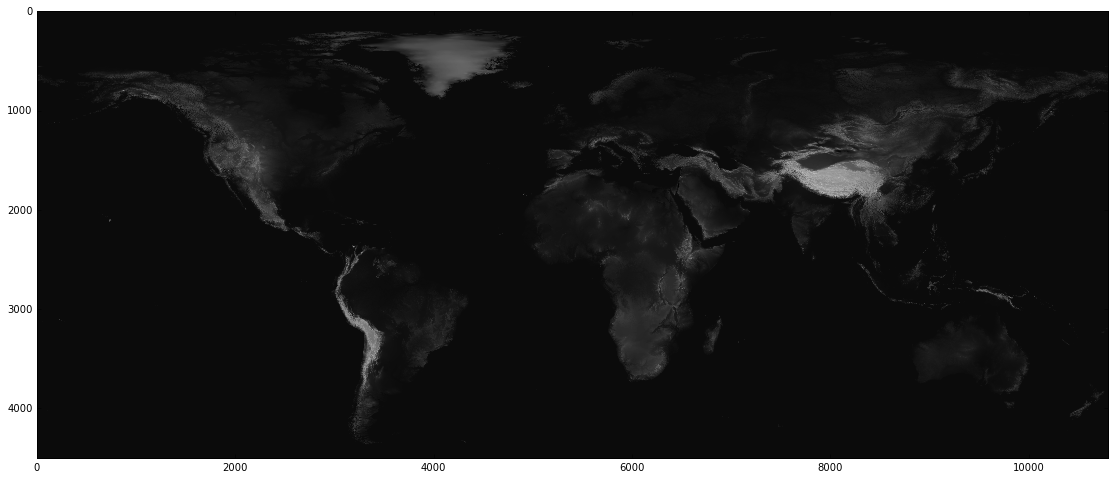

In [3]:
bigImage = np.load("bigImage.npy")
print "Size of full globe: ", bigImage.shape
bigImage=bigImage[::4,::4] #scale down by 1/4

plt.figure(figsize=(24, 8), dpi=80)
plt.imshow(bigImage, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

# Sea Level Rise Experiments

In the first figure we show the southeastern U.S. which makes up our system under investigation.

In the second figure we show the same location, but with all areas under 10m highlighted in white.

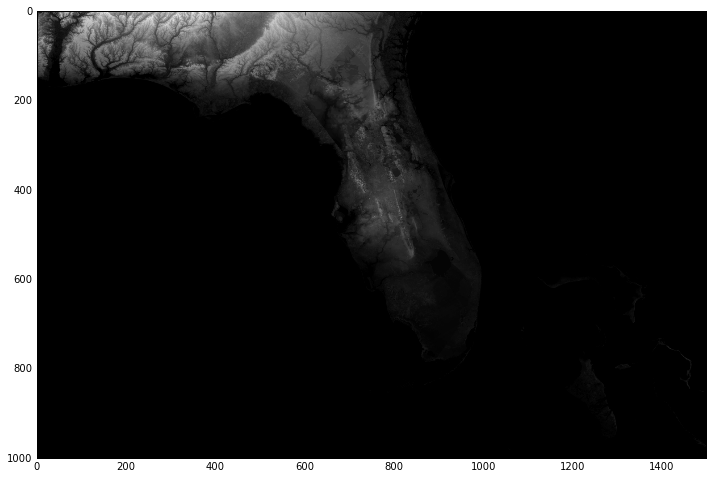

In [31]:
bigImage = np.load("data/bigImage.npy")
#bigImage=bigImage[6000:8000,10000:13000] #select the southeast area
bigImage = bigImage[7000:8000, 11000:12500]

maxVal = bigImage.mean()

bigImage[(bigImage<0) & (bigImage!=0)] = maxVal


plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bigImage,cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

Number of cells that are lower than 0: 126


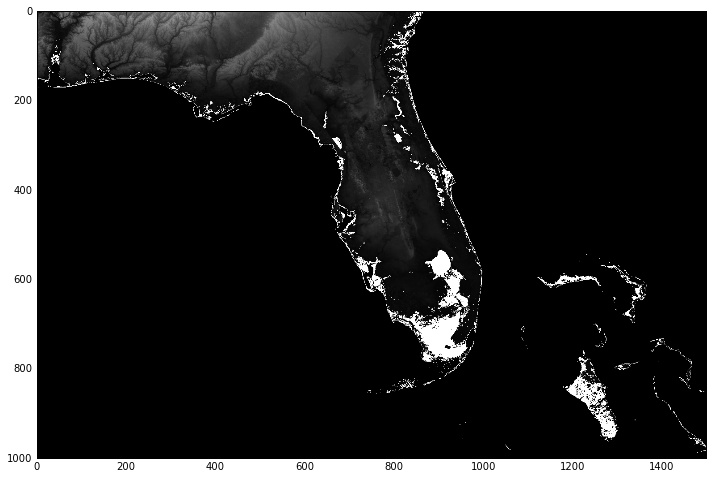

In [11]:
#Show locations that are under a certain meter rise

print "Number of cells that are lower than 0: %d" % (np.sum(bigImage<0))

maxVal = bigImage.max()
bigImage[(bigImage<6) & (bigImage!=0)] = maxVal
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bigImage, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

## Visualizing DFS Maps

In [9]:
import rasterio

In [36]:
src = rasterio.open("outputs/mask_%d.tif" % (6))
dataMask = src.read().squeeze()
src.close()

src = rasterio.open("usRaster.tif")
data = src.read().squeeze()
src.close()

print "Finished reading rasters"

Finished reading rasters


In [37]:
print data.shape
print dataMask.shape

(4649, 7544)
(4649, 7544)


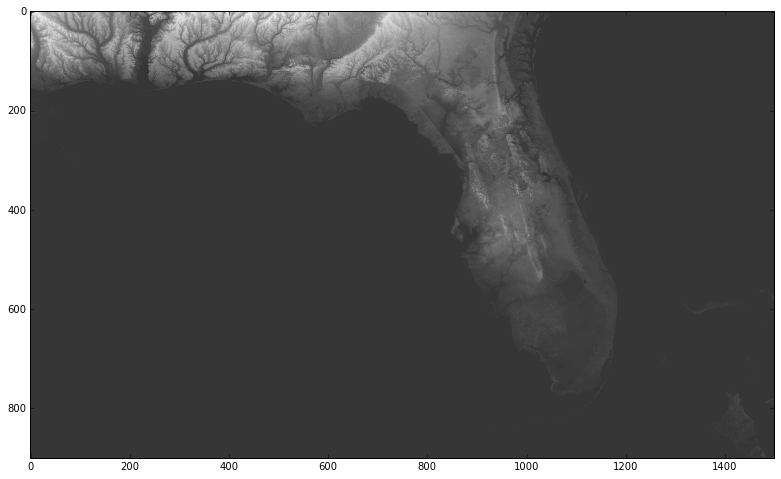

In [38]:
data = data[2300:3200, 4500:6000]
dataMask = dataMask[2300:3200, 4500:6000]

maxVal = data.max()

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

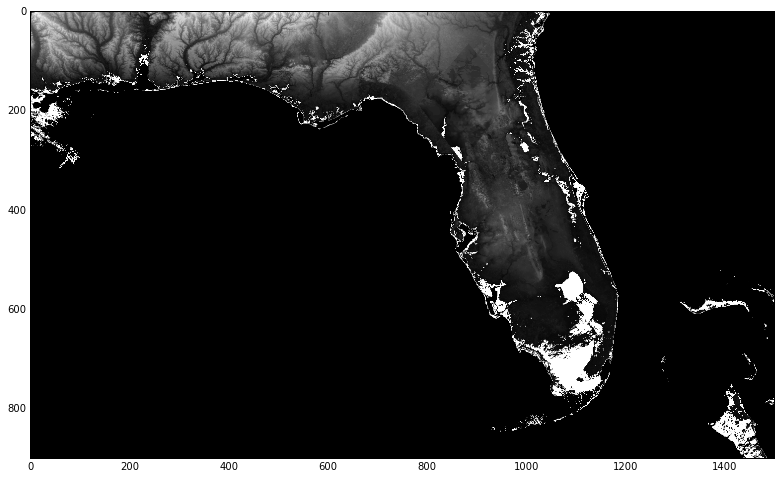

In [39]:
data1 = data.copy()
data1[(data1<6) & (data1!=0)] = maxVal

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data1, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

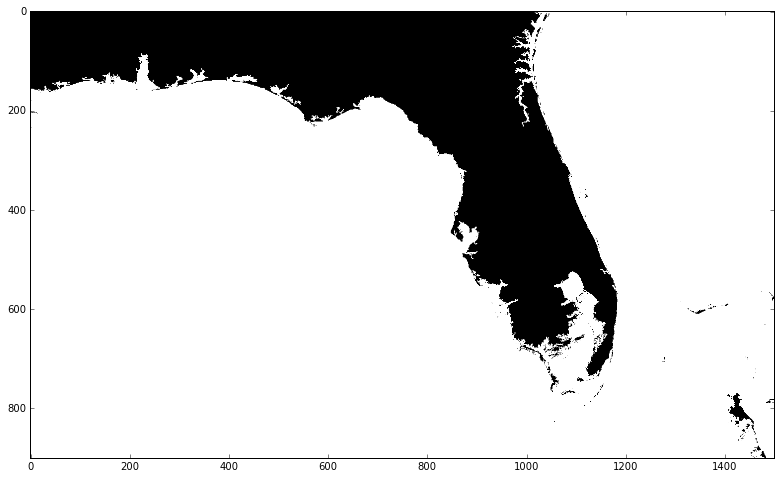

In [40]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(dataMask, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

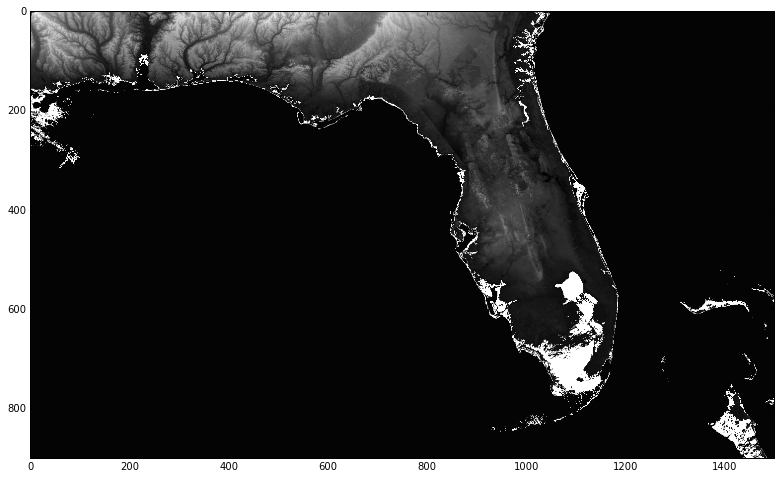

In [41]:
data2 = data.copy()
data2[(data1 == maxVal) & (dataMask == 1)] = maxVal


plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data2, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

## Southeast Maps

Finished reading rasters


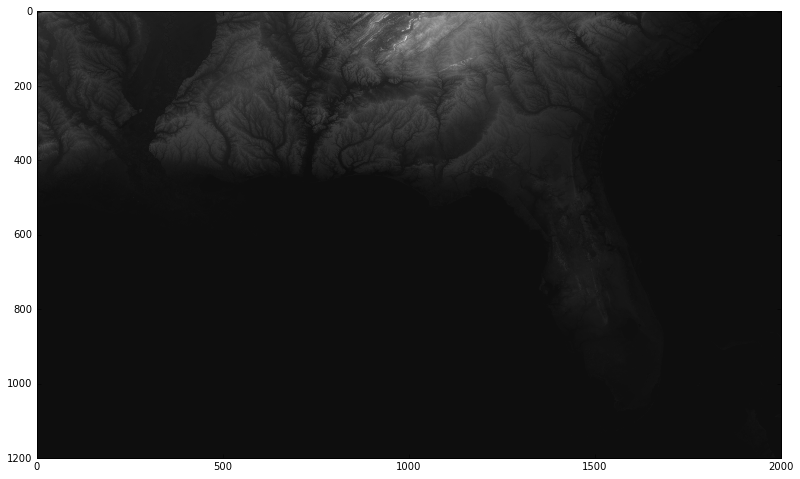

In [53]:
seaLevelRiseAmount = 10

src = rasterio.open("outputs/mask_%d.tif" % (seaLevelRiseAmount))
dataMask = src.read().squeeze()
src.close()

src = rasterio.open("usRaster.tif")
data = src.read().squeeze()
src.close()

print "Finished reading rasters"

#data = data[2300:3200, 4500:6000]
#dataMask = dataMask[2300:3200, 4500:6000]

data = data[2000:3200, 4000:6000]
dataMask = dataMask[2000:3200, 4000:6000]


maxVal = data.max()

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

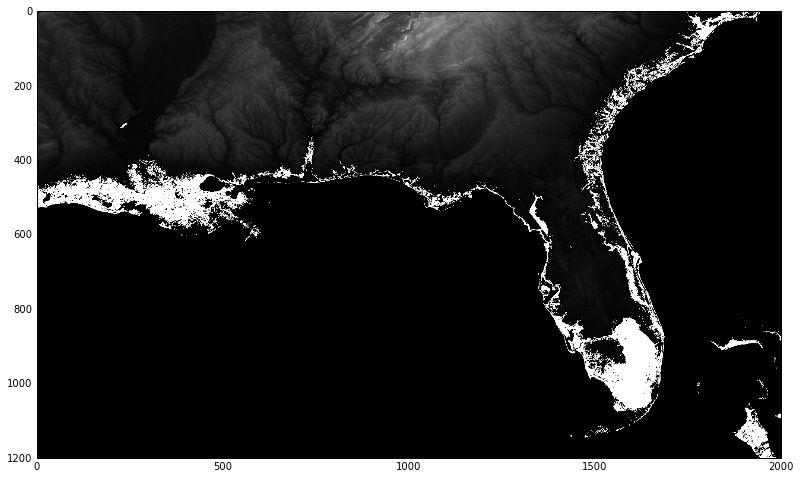

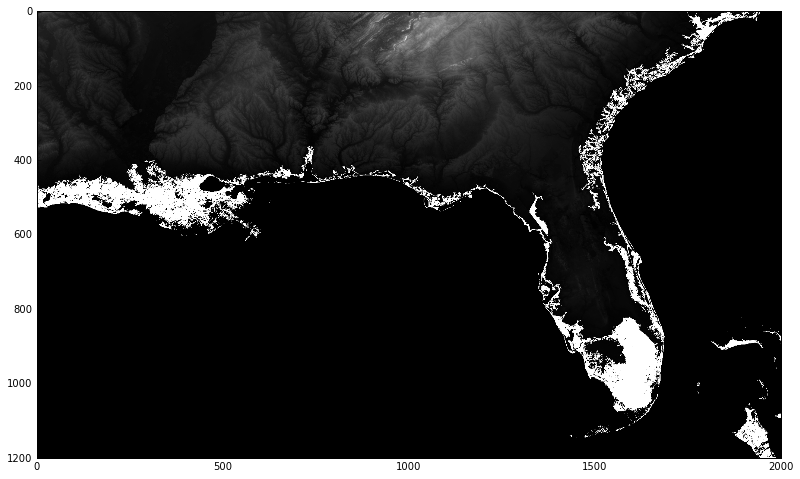

In [54]:
data1 = data.copy()
data1[(data1<seaLevelRiseAmount) & (data1!=0)] = maxVal

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data1, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()

data2 = data.copy()
data2[(data1 == maxVal) & (dataMask == 1)] = maxVal

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(data2, interpolation='bilinear',cmap=cm.gray,alpha=1.0)
plt.grid(False)
plt.show()